# Identify and gather data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = "Customer_Churn_Data_Large.xlsx"
all_sheets = pd.read_excel(file_path, sheet_name=None)

In [3]:
all_sheets.keys()

dict_keys(['Customer_Demographics', 'Transaction_History', 'Customer_Service', 'Online_Activity', 'Churn_Status'])

In [4]:
main_churn = all_sheets['Customer_Demographics']
Transaction_History = all_sheets['Transaction_History']
Customer_Service = all_sheets['Customer_Service']
Online_Activity = all_sheets['Online_Activity']
Churn_Status = all_sheets['Churn_Status']

In [5]:
main_churn.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel
0,1,62,M,Single,Low
1,2,65,M,Married,Low
2,3,18,M,Single,Low
3,4,21,M,Widowed,Low
4,5,21,M,Divorced,Medium


In [6]:
Transaction_History.head()

,CustomerID,TransactionID,TransactionDate,AmountSpent,ProductCategory
0,1,7194,2022-03-27,416.50,Electronics
1,2,7250,2022-08-08,54.96,Clothing
2,2,9660,2022-07-25,197.50,Electronics
3,2,2998,2022-01-25,101.31,Furniture
4,2,1228,2022-07-24,397.37,Clothing


Removing the columns TransactionID and TransactionDate as they don't have any significant impact on churn status

In [7]:
Transaction_History.drop(columns=["TransactionID", "TransactionDate"],inplace=True)

In [8]:
Customer_Service.head()

,CustomerID,InteractionID,InteractionDate,InteractionType,ResolutionStatus
0,1,6363,2022-03-31,Inquiry,Resolved
1,2,3329,2022-03-17,Inquiry,Resolved
2,3,9976,2022-08-24,Inquiry,Resolved
3,4,7354,2022-11-18,Inquiry,Resolved
4,4,5393,2022-07-03,Inquiry,Unresolved


Removing the columns InteractionID and InteractionDate as they also don't have any significant impact on churn status

In [9]:
Customer_Service.drop(columns=["InteractionID","InteractionDate"],inplace=True)

In [10]:
Online_Activity.head()

,CustomerID,LastLoginDate,LoginFrequency,ServiceUsage
0,1,2023-10-21,34,Mobile App
1,2,2023-12-05,5,Website
2,3,2023-11-15,3,Website
3,4,2023-08-25,2,Website
4,5,2023-10-27,41,Website


In [11]:
Churn_Status.head()

,CustomerID,ChurnStatus
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


# Performing EDA

In [12]:
# Count number of interactions per customer
transactions_per_customer = (
    Transaction_History
    .groupby('CustomerID')
    .size()
    .reset_index(name='Number_of_Transaction')
)

In [13]:
# Sum total amount spent by each customer
total_spent_per_customer = (
    Transaction_History
    .groupby('CustomerID')['AmountSpent']
    .sum()
    .reset_index(name='total_amount_spent')
)

In [14]:
unresolved_count = (
    Customer_Service[Customer_Service['ResolutionStatus'] != 'Resolved']
    .groupby('CustomerID')
    .size()
    .reset_index(name='Unresolved_Interactions')
)

In [15]:
resolved_count = (
    Customer_Service[Customer_Service['ResolutionStatus'] == 'Resolved']
    .groupby('CustomerID')
    .size()
    .reset_index(name='Resolved_Interactions')
)

In [16]:
# Count number of interactions per customer
interactions_per_customer = (
    Customer_Service
    .groupby('CustomerID')
    .size()
    .reset_index(name='Number_of_Interactions')
)

In [17]:
main_churn = main_churn.merge(
    unresolved_count, on='CustomerID', how='left'
)

main_churn = main_churn.merge(
    resolved_count, on='CustomerID', how='left'
)

main_churn = main_churn.merge(
    interactions_per_customer,
    on='CustomerID',
    how='left'
)

main_churn = main_churn.merge(
    transactions_per_customer,
    on='CustomerID',
    how='left'
)

main_churn = main_churn.merge(
    total_spent_per_customer,
    on='CustomerID',
    how='left'
)

main_churn = main_churn.merge(
    Online_Activity[['CustomerID', 'LoginFrequency']],
    on='CustomerID',
    how='left'
)

main_churn = main_churn.merge(
    Churn_Status,
    on='CustomerID',
    how='left'
)

In [18]:
main_churn.head()

,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,Unresolved_Interactions,Resolved_Interactions,Number_of_Interactions,Number_of_Transaction,total_amount_spent,LoginFrequency,ChurnStatus
0,1,62,M,Single,Low,NaN,1.0,1.0,1,416.50,34,0
1,2,65,M,Married,Low,NaN,1.0,1.0,7,1547.42,5,1
2,3,18,M,Single,Low,NaN,1.0,1.0,6,1702.98,3,0
3,4,21,M,Widowed,Low,1.0,1.0,2.0,5,917.29,2,0
4,5,21,M,Divorced,Medium,NaN,NaN,NaN,8,2001.49,41,0


In [19]:
main_churn.isnull().sum()

CustomerID                   0
Age                          0
Gender                       0
MaritalStatus                0
IncomeLevel                  0
Unresolved_Interactions    589
Resolved_Interactions      552
Number_of_Interactions     332
Number_of_Transaction        0
total_amount_spent           0
LoginFrequency               0
ChurnStatus                  0
dtype: int64

Here, the reason behind NaN values in Unresolved, Resolved and Total Interactions is that few customers have interacted and few not. Apart from that, it might happen that they don't have any unresolved or resolved interactions. Hence filling these values with 0.

In [20]:
main_churn = main_churn.fillna(0)

In [21]:
main_churn.isnull().sum()

CustomerID                 0
Age                        0
Gender                     0
MaritalStatus              0
IncomeLevel                0
Unresolved_Interactions    0
Resolved_Interactions      0
Number_of_Interactions     0
Number_of_Transaction      0
total_amount_spent         0
LoginFrequency             0
ChurnStatus                0
dtype: int64

In [22]:
main_churn.duplicated().isnull().sum()

np.int64(0)

In [23]:
main_churn = main_churn.set_index('CustomerID')

In [24]:
main_churn.head()

,Age,Gender,MaritalStatus,IncomeLevel,Unresolved_Interactions,Resolved_Interactions,Number_of_Interactions,Number_of_Transaction,total_amount_spent,LoginFrequency,ChurnStatus
CustomerID,,,,,,,,,,,
1,62,M,Single,Low,0.0,1.0,1.0,1,416.50,34,0
2,65,M,Married,Low,0.0,1.0,1.0,7,1547.42,5,1
3,18,M,Single,Low,0.0,1.0,1.0,6,1702.98,3,0
4,21,M,Widowed,Low,1.0,1.0,2.0,5,917.29,2,0
5,21,M,Divorced,Medium,0.0,0.0,0.0,8,2001.49,41,0


In [25]:
main_churn.describe(include='all')

,Age,Gender,MaritalStatus,IncomeLevel,Unresolved_Interactions,Resolved_Interactions,Number_of_Interactions,Number_of_Transaction,total_amount_spent,LoginFrequency,ChurnStatus
count,1000.000000,1000,1000,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
unique,NaN,2,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,F,Widowed,High,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,513,276,349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,43.267000,NaN,NaN,NaN,0.479000,0.523000,1.002000,5.054000,1267.074950,25.912000,0.204000
std,15.242311,NaN,NaN,NaN,0.621245,0.632353,0.816494,2.603433,738.590013,14.055953,0.403171
min,18.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,1.000000,9.800000,1.000000,0.000000
25%,30.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,3.000000,626.685000,13.750000,0.000000
50%,43.000000,NaN,NaN,NaN,0.000000,0.000000,1.000000,5.000000,1232.880000,27.000000,0.000000
75%,56.000000,NaN,NaN,NaN,1.000000,1.000000,2.000000,7.000000,1791.902500,38.000000,0.000000


In [26]:
main_churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      1000 non-null   int64  
 1   Gender                   1000 non-null   object 
 2   MaritalStatus            1000 non-null   object 
 3   IncomeLevel              1000 non-null   object 
 4   Unresolved_Interactions  1000 non-null   float64
 5   Resolved_Interactions    1000 non-null   float64
 6   Number_of_Interactions   1000 non-null   float64
 7   Number_of_Transaction    1000 non-null   int64  
 8   total_amount_spent       1000 non-null   float64
 9   LoginFrequency           1000 non-null   int64  
 10  ChurnStatus              1000 non-null   int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 93.8+ KB


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Unresolved_Interactions'}>,
        <Axes: title={'center': 'Resolved_Interactions'}>],
       [<Axes: title={'center': 'Number_of_Interactions'}>,
        <Axes: title={'center': 'Number_of_Transaction'}>,
        <Axes: title={'center': 'total_amount_spent'}>],
       [<Axes: title={'center': 'LoginFrequency'}>,
        <Axes: title={'center': 'ChurnStatus'}>, <Axes: >]], dtype=object)

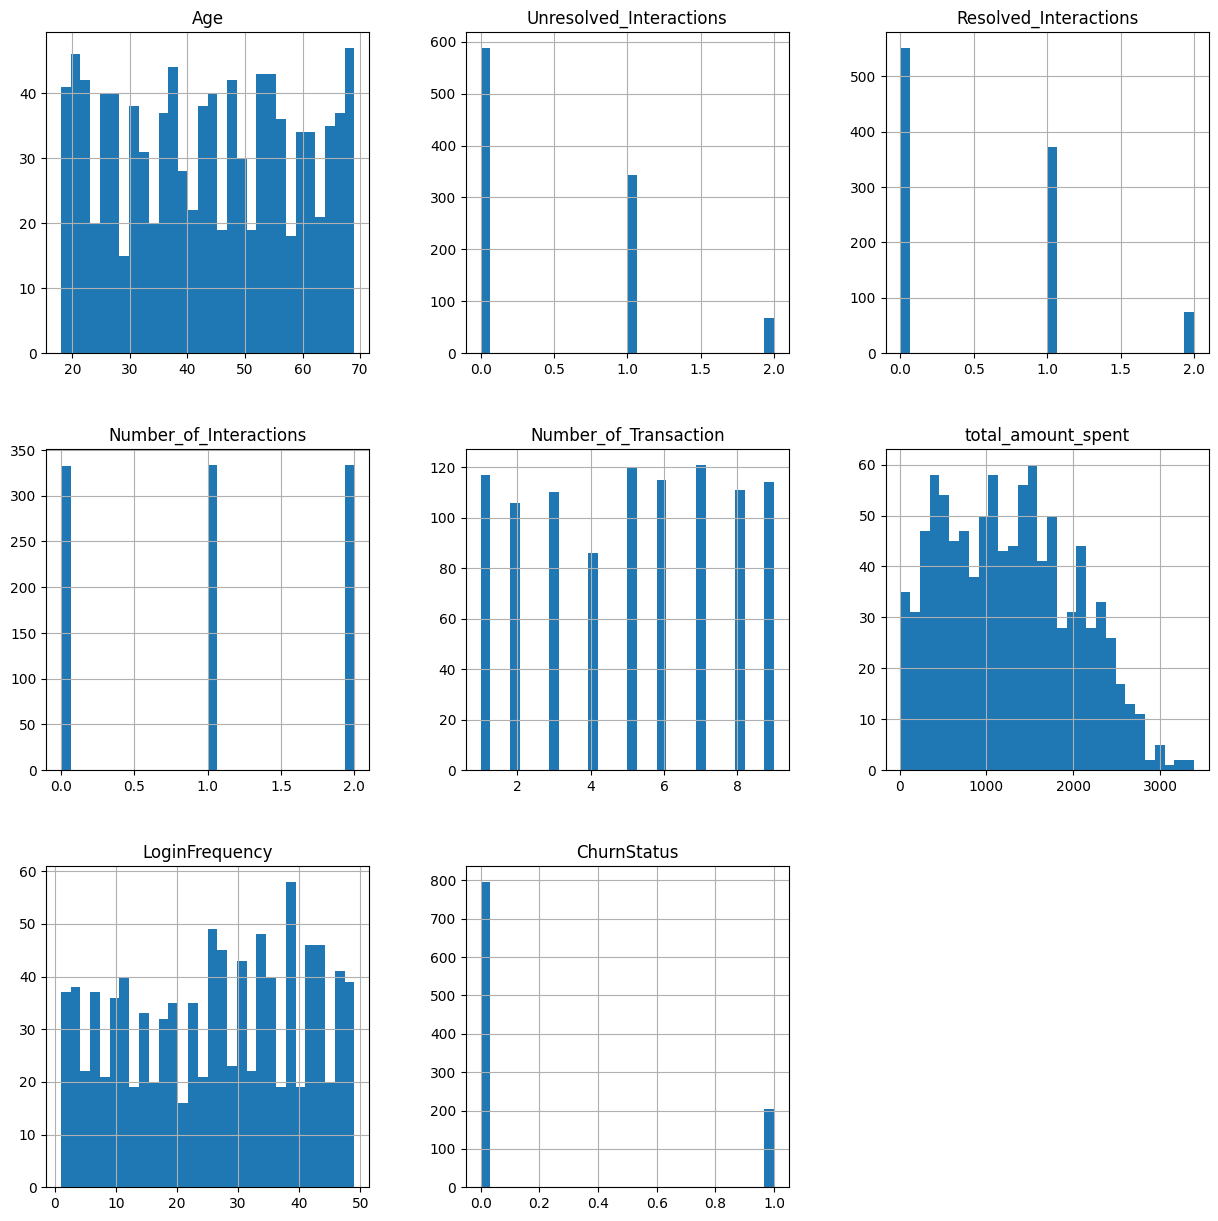

In [27]:
# ploting the histogram
main_churn.hist(bins=30, figsize=(15,15))

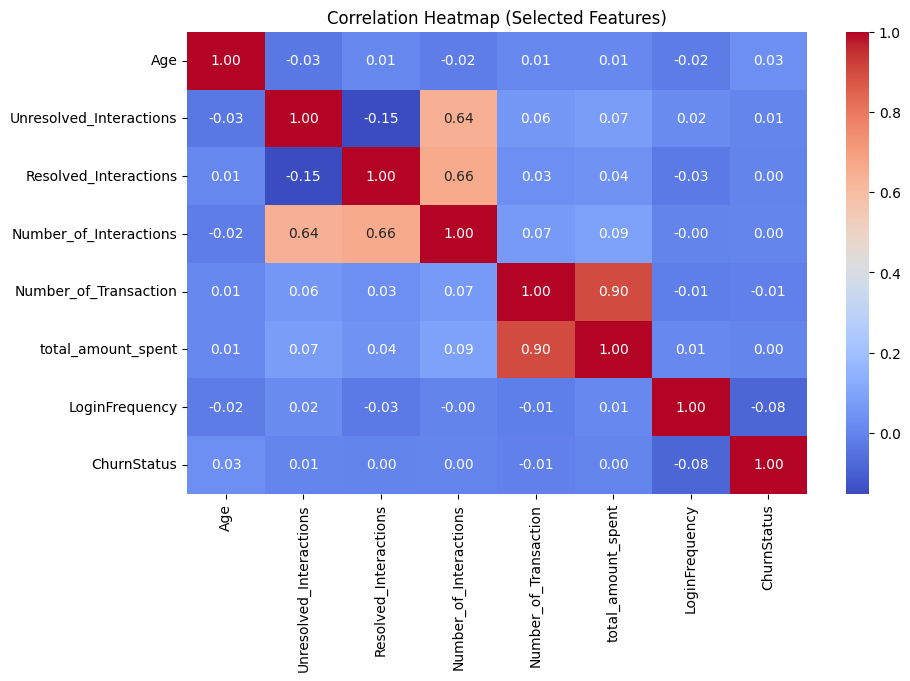

In [28]:
cols = [
    'Age',
    'Unresolved_Interactions',
    'Resolved_Interactions',
    'Number_of_Interactions',
    'Number_of_Transaction',
    'total_amount_spent',
    'LoginFrequency',
    'ChurnStatus'
]

corr_matrix = main_churn[cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Selected Features)')
plt.show()

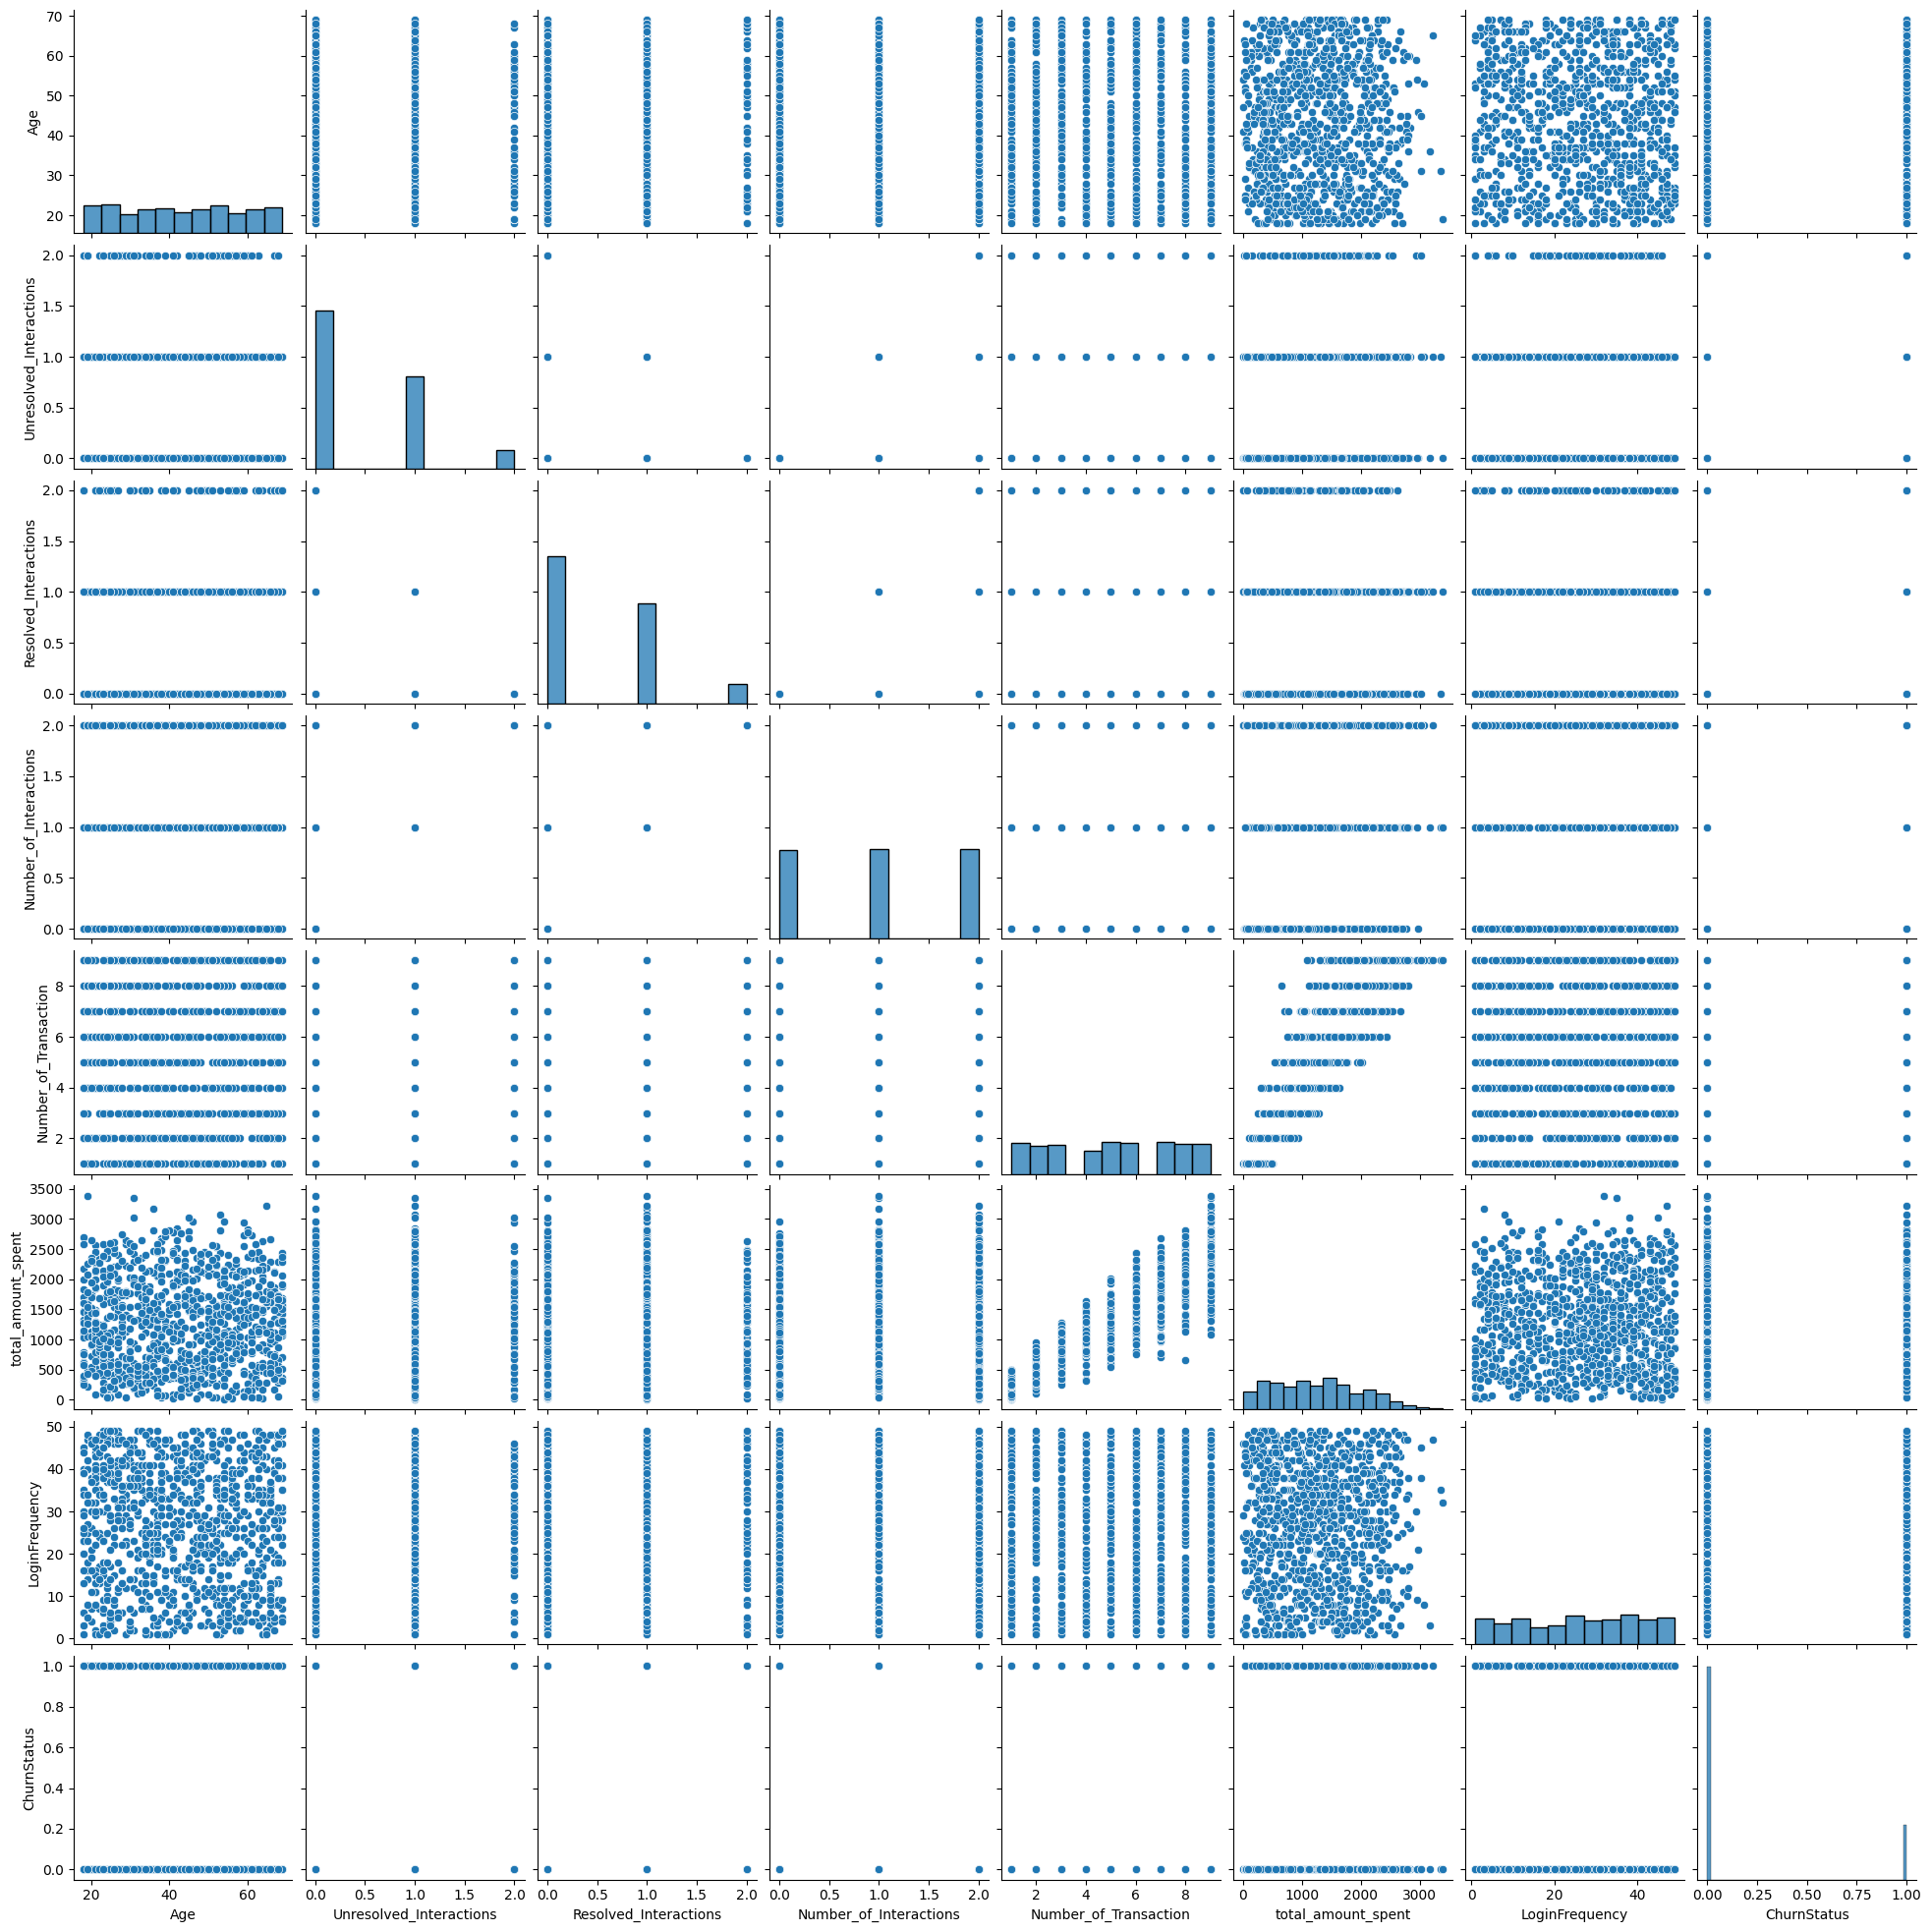

In [29]:
sns.pairplot(data=main_churn)

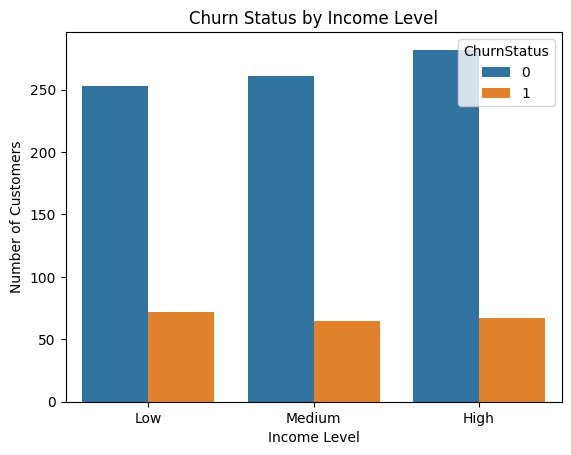

In [30]:
sns.countplot(
    x='IncomeLevel',
    hue='ChurnStatus',
    data=main_churn
)

plt.title("Churn Status by Income Level")
plt.xlabel("Income Level")
plt.ylabel("Number of Customers")
plt.show()

The analysis indicates a comparatively higher churn rate among customers in the low-income group, whereas customers in the high-income group exhibit stronger retention.

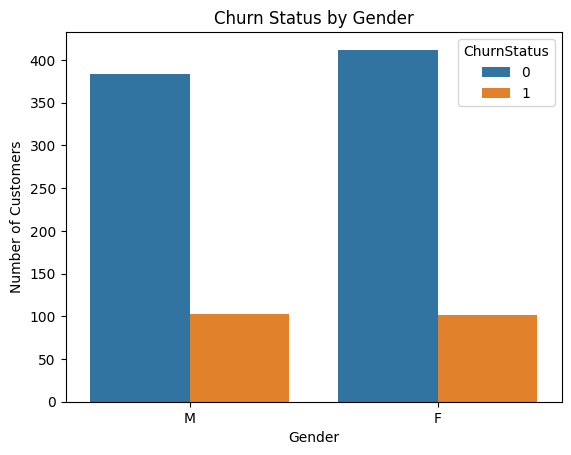

In [31]:
sns.countplot(
    x='Gender',
    hue='ChurnStatus',
    data=main_churn
)

plt.title("Churn Status by Gender")
plt.xlabel("Gender")
plt.ylabel("Number of Customers")
plt.show()

The analysis indicates a comparatively higher churn rate for males, whereas females exhibit stronger retention.

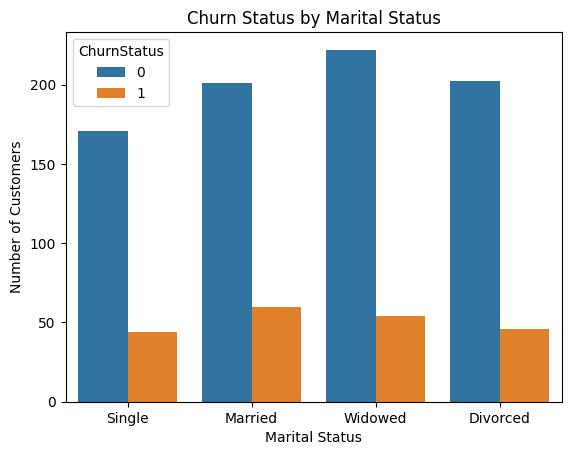

In [32]:
sns.countplot(
    x='MaritalStatus',
    hue='ChurnStatus',
    data=main_churn
)

plt.title("Churn Status by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Number of Customers")
plt.show()

The analysis indicates a comparatively higher churn rate for married customers, whereas widows exhibit stronger retention.

In [33]:
# Sum interactions grouped by churn
interactions_summary = main_churn.groupby('ChurnStatus')['Number_of_Interactions'].sum().reset_index()

interactions_summary

,ChurnStatus,Number_of_Interactions
0,0,796.0
1,1,206.0


C:\Users\SAKSHI\AppData\Local\Temp\ipykernel_3240\782225794.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


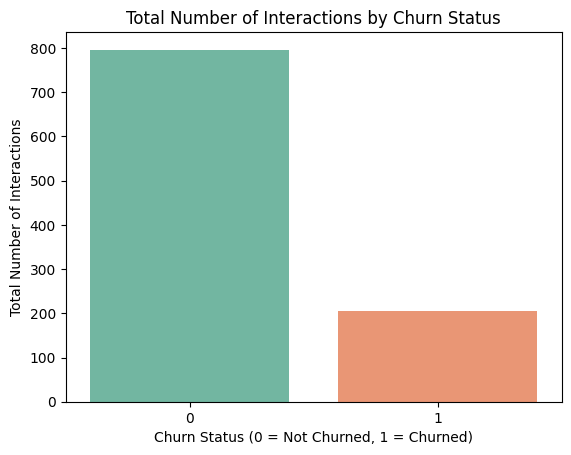

In [34]:
sns.barplot(
    x='ChurnStatus',
    y='Number_of_Interactions',
    data=interactions_summary,
    palette='Set2'
)

plt.title("Total Number of Interactions by Churn Status")
plt.xlabel("Churn Status (0 = Not Churned, 1 = Churned)")
plt.ylabel("Total Number of Interactions")
plt.show()

In [35]:
# Aggregate totals per churn
interaction_summary = main_churn.groupby('ChurnStatus')[['Resolved_Interactions', 'Unresolved_Interactions']].sum().reset_index()

# Melt to long format for seaborn
interaction_melted = interaction_summary.melt(
    id_vars='ChurnStatus',
    value_vars=['Resolved_Interactions', 'Unresolved_Interactions'],
    var_name='InteractionType',
    value_name='Total_Interactions'
)

interaction_melted

,ChurnStatus,InteractionType,Total_Interactions
0,0,Resolved_Interactions,416.0
1,1,Resolved_Interactions,107.0
2,0,Unresolved_Interactions,380.0
3,1,Unresolved_Interactions,99.0


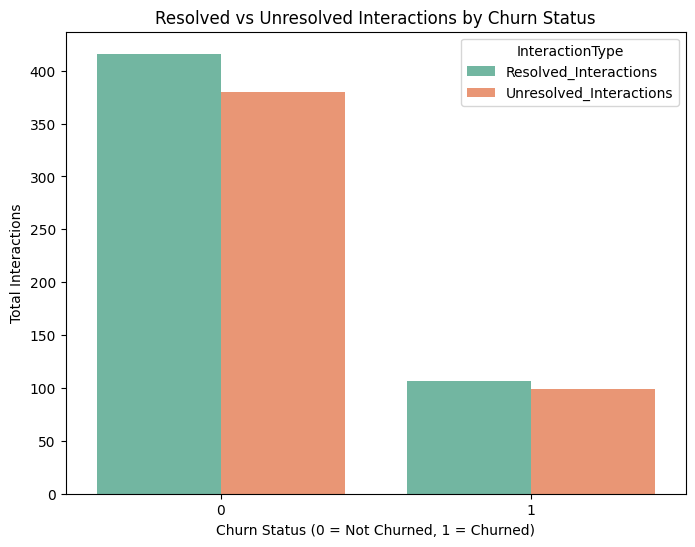

In [36]:
plt.figure(figsize=(8,6))

sns.barplot(
    x='ChurnStatus',
    y='Total_Interactions',
    hue='InteractionType',
    data=interaction_melted,
    palette='Set2'
)

plt.title("Resolved vs Unresolved Interactions by Churn Status")
plt.xlabel("Churn Status (0 = Not Churned, 1 = Churned)")
plt.ylabel("Total Interactions")
plt.show()

In [37]:
zero_interactions = (
    main_churn[main_churn['Number_of_Interactions'] == 0]
    .groupby('ChurnStatus')
    .size()
    .reset_index(name='Zero_Interaction_Customers')
)

zero_interactions


,ChurnStatus,Zero_Interaction_Customers
0,0,271
1,1,61


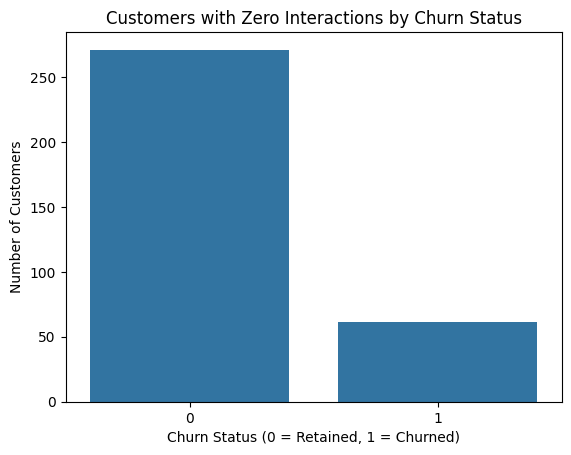

In [38]:
sns.barplot(
    data=zero_interactions,
    x='ChurnStatus',
    y='Zero_Interaction_Customers'
)
plt.title('Customers with Zero Interactions by Churn Status')
plt.xlabel('Churn Status (0 = Retained, 1 = Churned)')
plt.ylabel('Number of Customers')
plt.show()

In [39]:
product_count = (
    Transaction_History
    .groupby(['CustomerID', 'ProductCategory'])
    .size()
    .reset_index(name='Count')
)

product_count.head()

,CustomerID,ProductCategory,Count
0,1,Electronics,1
1,2,Clothing,2
2,2,Electronics,3
3,2,Furniture,1
4,2,Groceries,1


In [40]:
# Merge churn status into transaction history
transaction = Transaction_History.merge(
    Churn_Status[['CustomerID', 'ChurnStatus']],
    on='CustomerID',
    how='left'  # keeps all rows in transaction_history
)

# Check result
transaction.head()

,CustomerID,AmountSpent,ProductCategory,ChurnStatus
0,1,416.50,Electronics,0
1,2,54.96,Clothing,1
2,2,197.50,Electronics,1
3,2,101.31,Furniture,1
4,2,397.37,Clothing,1


In [41]:
# Count number of rows per product category per churn status
product_churn_summary = (
    transaction
    .groupby(['ChurnStatus', 'ProductCategory'])
    .size()
    .reset_index(name='CustomerCount')
)

product_churn_summary

,ChurnStatus,ProductCategory,CustomerCount
0,0,Books,844
1,0,Clothing,813
2,0,Electronics,776
3,0,Furniture,779
4,0,Groceries,820
5,1,Books,197
6,1,Clothing,187
7,1,Electronics,225
8,1,Furniture,213
9,1,Groceries,200


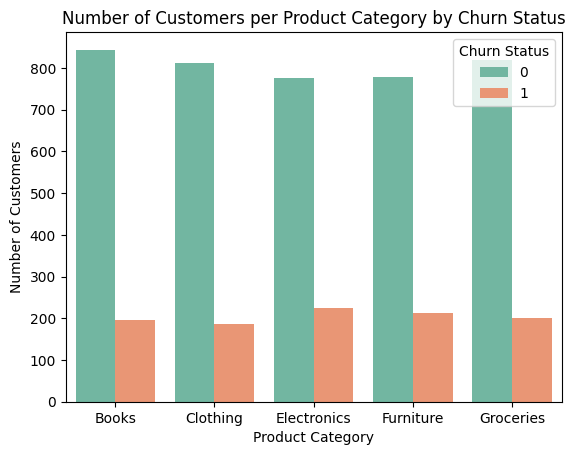

In [42]:
sns.barplot(
    x='ProductCategory',
    y='CustomerCount',
    hue='ChurnStatus',
    data=product_churn_summary,
    palette='Set2'
)

plt.title("Number of Customers per Product Category by Churn Status")
plt.xlabel("Product Category")
plt.ylabel("Number of Customers")
plt.legend(title="Churn Status")
plt.show()

The analysis indicates a comparatively higher churn rate for customers buying electronics item, whereas customers buying books exhibit stronger retention.

In [43]:
# Sum total transactions and interactions by churn status
churn_summary = main_churn.groupby('ChurnStatus')[['Number_of_Transaction', 'Number_of_Interactions']].sum().reset_index()

churn_summary

,ChurnStatus,Number_of_Transaction,Number_of_Interactions
0,0,4032,796.0
1,1,1022,206.0


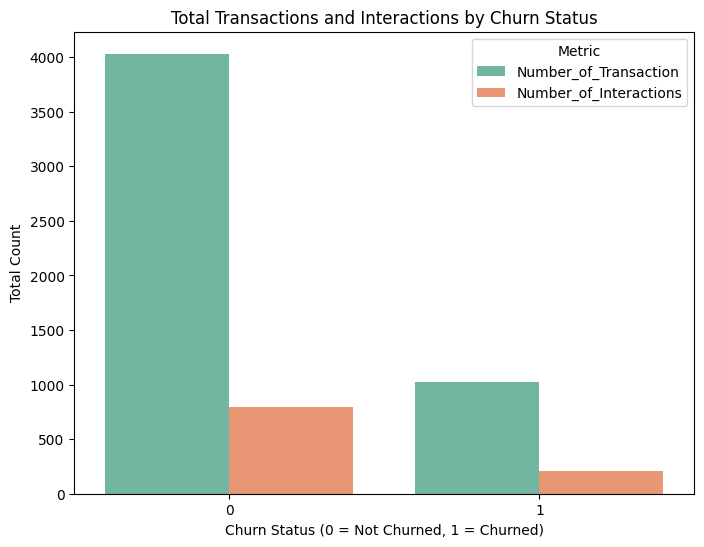

In [44]:
plt.figure(figsize=(8,6))

# Melt data for seaborn
churn_summary_melted = churn_summary.melt(id_vars='ChurnStatus', 
                                          value_vars=['Number_of_Transaction', 'Number_of_Interactions'],
                                          var_name='Metric', 
                                          value_name='Total')

sns.barplot(
    x='ChurnStatus',
    y='Total',
    hue='Metric',
    data=churn_summary_melted,
    palette='Set2'
)

plt.title("Total Transactions and Interactions by Churn Status")
plt.xlabel("Churn Status (0 = Not Churned, 1 = Churned)")
plt.ylabel("Total Count")
plt.show()

In [45]:
churn_summary['Interaction_Percentage'] = (
    churn_summary['Number_of_Interactions'] /
    churn_summary['Number_of_Transaction']
) * 100

In [46]:
churn_summary

,ChurnStatus,Number_of_Transaction,Number_of_Interactions,Interaction_Percentage
0,0,4032,796.0,19.742063
1,1,1022,206.0,20.156556


The results indicate that the interaction-to-transaction ratio is approximately 20% for both churned and non-churned customers. This similarity suggests that customer interactions have a minimal impact on churn status. Therefore, the ‘Number_of_Interactions’ feature can be considered for removal from the main dataset.

In [47]:
# Sum total amount per product category per churn status
product_amount_summary = (
    transaction
    .groupby(['ProductCategory', 'ChurnStatus'])['AmountSpent']
    .sum()
    .reset_index(name='AmountSpent')
)

product_amount_summary

,ProductCategory,ChurnStatus,AmountSpent
0,Books,0,210120.13
1,Books,1,49444.86
2,Clothing,0,205690.67
3,Clothing,1,46760.03
4,Electronics,0,192660.32
5,Electronics,1,56479.47
6,Furniture,0,193183.37
7,Furniture,1,51602.45
8,Groceries,0,206543.22
9,Groceries,1,54590.43


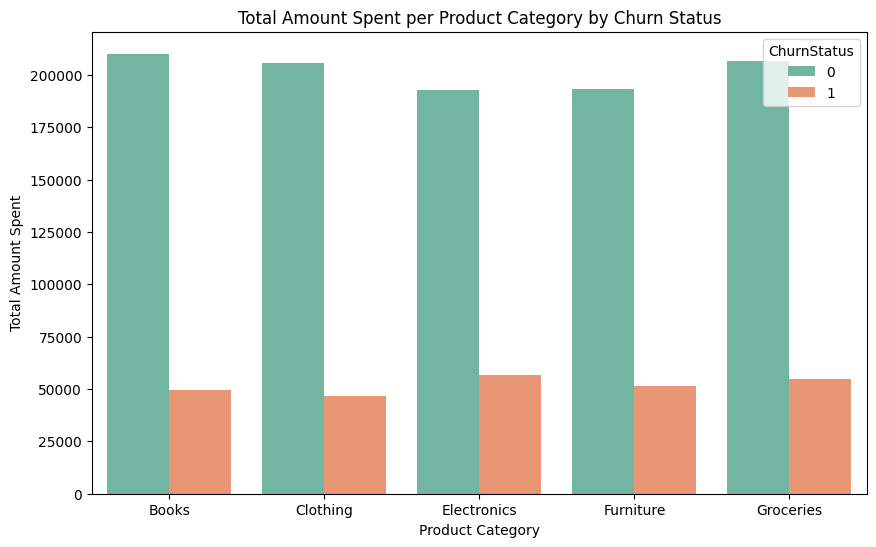

In [48]:
plt.figure(figsize=(10,6))

sns.barplot(
    x='ProductCategory',
    y='AmountSpent',
    hue='ChurnStatus',
    data=product_amount_summary,
    palette='Set2'
)

plt.title("Total Amount Spent per Product Category by Churn Status")
plt.xlabel("Product Category")
plt.ylabel("Total Amount Spent")
plt.show()

In [49]:
# Sum total_amount_spent for each churn status
amount_summary = main_churn.groupby('ChurnStatus')['total_amount_spent'].sum().reset_index()

amount_summary

,ChurnStatus,total_amount_spent
0,0,1008197.71
1,1,258877.24


C:\Users\SAKSHI\AppData\Local\Temp\ipykernel_3240\1108446786.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


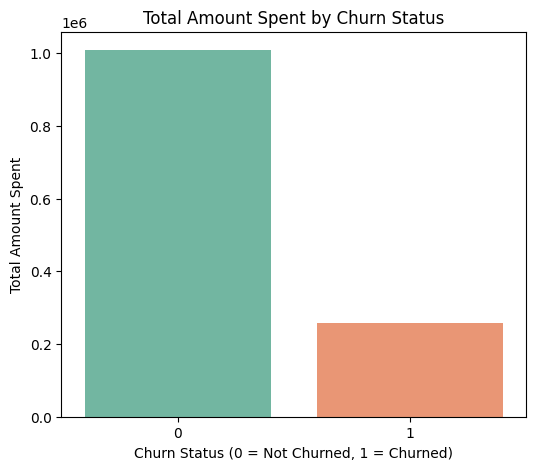

In [50]:
plt.figure(figsize=(6,5))

sns.barplot(
    x='ChurnStatus',
    y='total_amount_spent',
    data=amount_summary,
    palette='Set2'
)

plt.title("Total Amount Spent by Churn Status")
plt.xlabel("Churn Status (0 = Not Churned, 1 = Churned)")
plt.ylabel("Total Amount Spent")
plt.show()

The analysis indicates a comparatively higher churn rate for customers spending to buy electronics item, whereas exhibit stronger retention when customer spends more for books.

# Clean and preprocess the data

In [54]:
from sklearn.preprocessing import LabelEncoder

In [55]:
# Example columns
cols_to_encode = ['Gender', 'MaritalStatus', 'IncomeLevel']

In [56]:
le = LabelEncoder()

for col in cols_to_encode:
    main_churn[col] = le.fit_transform(main_churn[col])

In [57]:
main_churn.head(10)

,Age,Gender,MaritalStatus,IncomeLevel,Unresolved_Interactions,Resolved_Interactions,Number_of_Interactions,Number_of_Transaction,total_amount_spent,LoginFrequency,ChurnStatus
CustomerID,,,,,,,,,,,
1,62,1,2,1,0.0,1.0,1.0,1,416.50,34,0
2,65,1,1,1,0.0,1.0,1.0,7,1547.42,5,1
3,18,1,2,1,0.0,1.0,1.0,6,1702.98,3,0
4,21,1,3,1,1.0,1.0,2.0,5,917.29,2,0
5,21,1,0,2,0.0,0.0,0.0,8,2001.49,41,0
6,57,0,0,2,0.0,1.0,1.0,5,1164.29,2,0
7,27,0,1,0,0.0,0.0,0.0,1,86.73,32,0
8,37,1,2,1,2.0,0.0,2.0,7,2046.88,17,1
9,39,1,0,0,0.0,1.0,1.0,5,1317.24,24,0


In [58]:
main_churn.drop(
    columns=['Unresolved_Interactions', 'Resolved_Interactions', 'Number_of_Interactions'],
    inplace=True
)

In [59]:
main_churn.head()

,Age,Gender,MaritalStatus,IncomeLevel,Number_of_Transaction,total_amount_spent,LoginFrequency,ChurnStatus
CustomerID,,,,,,,,
1,62,1,2,1,1,416.50,34,0
2,65,1,1,1,7,1547.42,5,1
3,18,1,2,1,6,1702.98,3,0
4,21,1,3,1,5,917.29,2,0
5,21,1,0,2,8,2001.49,41,0


In [60]:
main_churn.shape

(1000, 8)

This table represents the final dataset to be used for subsequent analysis and model development.

# Building a machine learning model

In [62]:
x = main_churn.iloc[:,:-1]
y = main_churn['ChurnStatus']

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

In [64]:
# Split data
X = main_churn.drop(columns=['ChurnStatus'])
y = main_churn['ChurnStatus']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [65]:
# Random Forest model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

In [66]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [67]:
# GridSearchCV
grid_search = GridSearchCV(
    rf,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

In [68]:
# Fit model
grid_search.fit(X_train, y_train)


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [200, 300, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and paramet

In [69]:
# Best model
best_model = grid_search.best_estimator_

In [70]:
# Predictions
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

In [71]:
# Evaluation
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("Best ROC-AUC Score:", roc_auc)
print("Best Parameters:", grid_search.best_params_)

Best ROC-AUC Score: 0.5112747353888634
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
